Looks like sims_coordUtils has dcr calc's already built in - let's try using those.  
First, need to
```
setup -t b1740 sims_coordUtils
```

In [9]:
import os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.style.use('ggplot')
## see http://matplotlib.org/users/colormaps.html for colormaps
from matplotlib import cm

import pandas as pd

## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

First compare to results of S14 and chroma

In [43]:
import lsst.sims.coordUtils.AstrometryUtils as au
import lsst.sims.utils.Site as Site

P = 520.0
T = 20.0
f = 8.0
## set these to exactly the same values as in S14 code...
pressure = P / 7.50061683 * 10. ## kilopascal to millibars
temperature = T + 273.15
H2O_pressure = f / 7.5006168
print pressure

## meanTemperature=284.655, meanPressure=749.3, meanHumidity=0.4
lsstSite = Site(meanTemperature=temperature, meanPressure=pressure)

zd = 40. * np.pi / 180.
print zd

wave1 = 625.
refco = au.refractionCoefficients(wave1/1000., lsstSite) ## takes wavelength in microns
ref1 = (au.applyRefraction(zd, refco[0], refco[1]) - zd) * 180.0 / np.pi * 3600.

wave2 = 350.
refco = au.refractionCoefficients(wave2/1000., lsstSite) ## wavelength in microns
ref2 = (au.applyRefraction(zd, refco[0], refco[1]) - zd) * 180.0 / np.pi * 3600.

print ref2 - ref1

693.276315516
0.698131700798
-1.09413880304


OK, pretty close to value of -1.1090956807 from S14 and chroma -- note that I'm not sure how to get the H2O pressure the same so these results are pretty good.

How do I convert kilopascals of H2O pressure into the "humidity" expected by `Site`?  
Update -- apparently `meanHumidity` doesn't affect the results at all.

## OK, I have deduced that there is a difference  
between the way these offsets are calculated (using the pal library) and they way `chroma` and `S14` do it.
See [here](https://github.com/Starlink/pal/blob/master/palRefz.c).   
The `palpy` routines are used for the sims, to do from unrefracted to refracted. We want to go the other way which is not just a matter of negating the output.  
This needs to be investigated more.  

OK, I investigated it ... `au.applyRefraction()` uses `palpy.refco()` whereas we want to use `palpy.refro`. So let's do that...

Just some notes from the `palRefro` code. It uses a different function to compute DCR than the Fillipenko one used in my other notebooks...  
```
- The routine computes the refraction for zenith distances up
*     to and a little beyond 90 deg using the method of Hohenkerk
*     and Sinclair (NAO Technical Notes 59 and 63, subsequently adopted
*     in the Explanatory Supplement, 1992 edition - see section 3.281).
```
This reference is [here](http://astro.ukho.gov.uk/data/tn/naotn63.pdf) !!! It is worth a read.

see other possibly relevant notes [here](https://github.com/Starlink/pal/blob/master/palRefro.c).

In [80]:
import palpy
import lsst.sims.utils.Site as Site

P = 520.0
T = 20.0
f = 8.0
## set these to exactly the same values as in S14 code...
pressure = P / 7.50061683 * 10. ## kilopascal to millibars
temperature = T + 273.15
H2O_pressure = f / 7.5006168
print pressure

site = Site(meanTemperature=temperature, meanPressure=pressure)

def computeRefro(zd, wavelength, site):
    ref1 = palpy.refro(zd, site.height,
                    site.meanTemperature,
                    site.meanPressure,
                    site.meanHumidity,
                    wavelength/1000.,
                    site.latitude,
                    site.lapseRate,
                    1.e-8) * 180.0 / np.pi * 3600.
    return ref1

zd = 40. * np.pi / 180.
print zd

wave1 = 625.
ref1 = computeRefro(zd, wave1, site)

wave2 = 350.
ref2 = computeRefro(zd, wave2, site)

print (ref2 - ref1)

693.276315516
0.698131700798
1.09485775786


### OK, let's do the same SED-based DCR calc's as in the S14 test notebook...

In [81]:
import lsst.sims.photUtils.Sed as Sed
import lsst.sims.photUtils.Bandpass as Bandpass
import lsst.sims.photUtils.BandpassDict as bpDict

bpDir = os.environ['LSST_THROUGHPUTS_DEFAULT']
catDir = os.environ['SIMS_SED_LIBRARY_DIR']
star_SEDname = "km15_5250.fits_g05_5470.gz"
star = Sed()
star.readSED_flambda(os.path.join(catDir, "starSED/%s/%s%s" % ('kurucz', star_SEDname, '')))
star.flambdaTofnu()

bps = bpDict.loadTotalBandpassesFromFiles()
for bp in bps.keys():
    bpobj = bps[bp]
    bpobj.phi[bpobj.phi <= 1.e-4] = 0.
    bpobj.phi[(bpobj.wavelen > bpobj.wavelen_max)] = 0.
    bpobj.phi[(bpobj.wavelen < bpobj.wavelen_min)] = 0.
    
#waveleng, fnug = star.resampleSED(star.wavelen, star.fnu, wavelen_match=bps['g'].wavelen)
#nphotong = fnug / waveleng
#plt.plot(waveleng[(waveleng > 500) & (waveleng < 1000)], nphotong[(waveleng > 500) & (waveleng < 1000)])

In [96]:
airmass1   = 1.25                                                                                                                                       
dairmasses = np.arange(-0.25, 0.26, 0.05)                                                                                                               
dthetas    = np.arange(0, 181, 5)
zd1        = np.arccos(1./airmass1)# * 180/np.pi

waveleng, fnug = star.resampleSED(star.wavelen, star.fnu, wavelen_match=bps['g'].wavelen)
fnug[0] = 0.   ## is nan for some reason?
#dg1 = getOffset(waveleng, fluxg, zd1)

off = np.array([computeRefro(zd1, wave, site) for wave in waveleng])
    
#print refracts
fluxg = fnug * bps['g'].phi
dg1 = np.sum(off * fluxg) / np.sum(fluxg)
print dg1
print dg1 - 29.005276987

28.9777750442
-0.0275019427989
28.9777750442


### Whew, this is 0.0275 arcsec off of the `S14` estimate. Is that okay?

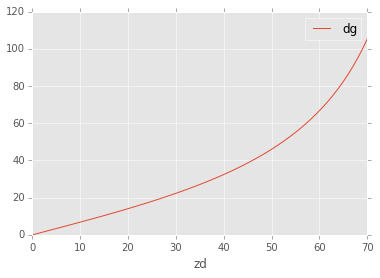

In [97]:
def getOffset(wavelen, flux, zd, site):
    off = np.array([computeRefro(zd, wave, site) for wave in waveleng])
    dg1 = np.sum(off * flux) / np.sum(flux)
    return dg1
    
print getOffset(waveleng, fluxg, zd1, site)

angles = np.linspace(0,70,71)
#for zd in angles:
#    print zd, getOffset(waveleng, fluxg, zd * np.pi / 180., site)

dg2 = np.array([getOffset(waveleng, fluxg, zd * np.pi / 180., site) for zd in angles])   ## in zd2])
tmp_df = pd.DataFrame({'zd': angles, 'dg': dg2})
tmp_df.plot(x='zd', y='dg')

### Now could try to speed this up by using `palpy.refroVector()`...  
But in this func., zd is the vector (would be nice if wavelength was the vector instead...).  
Might have to reimplement such a thing, if we go with these functions.  
This is still slow...

[ 1.09485776]
[ 28.97777504]


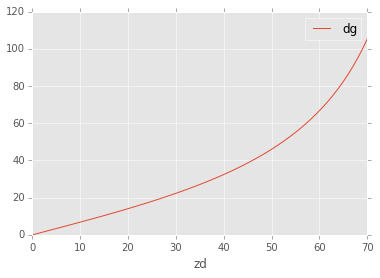

In [126]:
def computeRefroV(zd, wavelength, site):
    ref1 = palpy.refroVector(zd * np.pi / 180., site.height,
                    site.meanTemperature,
                    site.meanPressure,
                    site.meanHumidity,
                    wavelength/1000.,
                    site.latitude,
                    site.lapseRate,
                    1.e-8) * 180.0 / np.pi * 3600.
    return ref1

zd = np.array([40.])
wave1 = 625.
ref1 = computeRefroV(zd, wave1, site)
wave2 = 350.
ref2 = computeRefroV(zd, wave2, site)
print (ref2 - ref1)

#angles = np.linspace(0,70,71)  * np.pi / 180.
#off = np.array([computeRefroV(angles, wave1, site) for wave in waveleng])
#print len(angles), len(waveleng), off.shape

def getOffsets(wavelen, flux, zds, site):
    off = np.array([computeRefroV(zds, wave, site) for wave in waveleng])
    dg1 = off.T.dot(flux) / np.sum(flux)
    return dg1
    
print getOffsets(waveleng, fluxg, np.array([zd1]) / np.pi * 180., site)

angles = np.linspace(0,70,71)
#for zd in angles:
#    print zd, getOffset(waveleng, fluxg, zd, site)

dg2 = getOffsets(waveleng, fluxg, angles, site)
tmp_df = pd.DataFrame({'zd': angles, 'dg': dg2})
tmp_df.plot(x='zd', y='dg')

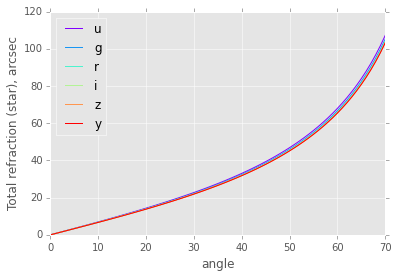

In [127]:
def compute_dcr(SED, site, filters='ugrizy', angles=np.linspace(0,70,71), relative=None, **kwargs):
    df = pd.DataFrame(pd.Series(angles)) #, index=pd.Series(angles))
    for filter_ in filters:
        wavelen, fnu = SED.resampleSED(SED.wavelen, SED.fnu, wavelen_match=bps[filter_].wavelen)
        fnu[0] = 0. ## is nan for some reason?
        flux = fnu * bps[filter_].phi

        ##dg2 = np.array([getOffset(wavelen, flux, zd) for zd in angles])
        dg2 = getOffsets(wavelen, flux, angles, site)
        #tmp_df = pd.DataFrame({'zd': angles, 'dg': dg2})
        df = pd.concat([df, pd.Series(dg2)], axis=1, ignore_index=True)

    df.columns = np.insert(np.array(list(filters), dtype='S6'), 0, 'angle')
    df = df.set_index('angle')
    if relative is not None and np.any(df.columns.values == relative):
        df2 = df.copy().sub(df[relative], axis=0)
        return df2
    return df

angles = np.linspace(0,70,71)
df = compute_dcr(star, site, 'ugrizy', angles)
ax = df.plot(colormap=cm.rainbow)
ax.set_ylabel('Total refraction (star), arcsec')

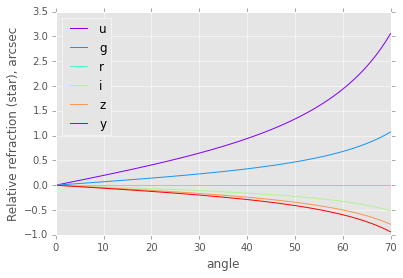

In [128]:
df2 = df.copy().sub(df['r'], axis=0)
ax = df2.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative refraction (star), arcsec')

In [129]:
sizeme(df2.tail())

,u,g,r,i,z,y
angle,,,,,,
66,2.503557,0.879295,0,-0.422750,-0.644635,-0.769921
67,2.624468,0.921760,0,-0.443166,-0.675767,-0.807104
68,2.755513,0.967784,0,-0.465294,-0.709508,-0.847402
69,2.898098,1.017862,0,-0.489369,-0.746220,-0.891250
70,3.053900,1.072581,0,-0.515677,-0.786335,-0.939161


In [130]:
import pickle
df_chroma = pickle.load(open("save2.p", "rb"))
sizeme((df - df_chroma).tail())

,u,g,r,i,z,y
angle,,,,,,
66,-0.594071,-0.561685,-0.551468,-0.547930,-0.546314,-0.545460
67,-0.679850,-0.644911,-0.633668,-0.629704,-0.627876,-0.626905
68,-0.781960,-0.744095,-0.731655,-0.727188,-0.725109,-0.724000
69,-0.904408,-0.863163,-0.849315,-0.844250,-0.841871,-0.840596
70,-1.052434,-1.007248,-0.991729,-0.985946,-0.983206,-0.981730


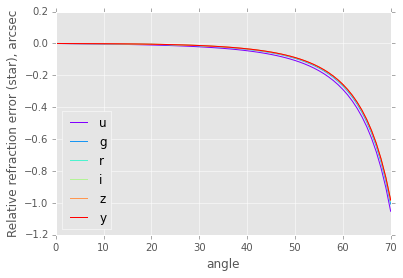

In [131]:
ax = (df - df_chroma).plot(colormap=cm.rainbow)
ax.set_ylabel('Relative refraction error (star), arcsec')

## OK, this could explain the 'issue' in Becker's W14 analyses --  
looks like phoSim uses a different function to approximate DCR in the output images than the one `W14` used to predict it.

So the question is - which DCR estimate function do we use? If we are estimating it from simulated images we obviously need to use the same function that generates it.